# Statystyka praktyczna w data science (Python)
# Rozdział 1. Badania eksploracyjne
> (c) 2019 Peter C. Bruce, Andrew Bruce, Peter Gedeck

Importuje wymagane pakiety Pythona.

In [1]:
%matplotlib inline

from pathlib import Path

import pandas as pd
import numpy as np
from scipy.stats import trim_mean
from statsmodels import robust
import wquantiles

import seaborn as sns
import matplotlib.pylab as plt

Definiuje ścieżki do zestawów danych. Jeżeli przechowujesz dane w innym katalogu, wprowadź poniżej stosowne zmiany.

In [2]:
DATA = Path('.').resolve().parents[1] / 'dane'

AIRLINE_STATS_CSV = DATA / 'airline_stats.csv'
KC_TAX_CSV = DATA / 'kc_tax.csv.gz'
LC_LOANS_CSV = DATA / 'lc_loans.csv'
AIRPORT_DELAYS_CSV = DATA / 'dfw_airline.csv'
SP500_DATA_CSV = DATA / 'sp500_data.csv.gz'
SP500_SECTORS_CSV = DATA / 'sp500_sectors.csv'
STATE_CSV = DATA / 'state.csv'

# Miary położenia
## Przykład: miara położenia dla wielkości populacji i wskaźnika morderstw

In [3]:
# Tabela 1.2
state = pd.read_csv(STATE_CSV)
print(state.head(8))

         State  Population  Murder.Rate Abbreviation
0      Alabama     4779736          5.7           AL
1       Alaska      710231          5.6           AK
2      Arizona     6392017          4.7           AZ
3     Arkansas     2915918          5.6           AR
4   California    37253956          4.4           CA
5     Colorado     5029196          2.8           CO
6  Connecticut     3574097          2.4           CT
7     Delaware      897934          5.8           DE


Oblicza średnią, średnią ucinaną i medianę kolumny Population. W przypadku `średniej` i `mediany` możemy skorzystać z metod ramki danych w pakiecie _pandas_. Średnia ucinana wymaga funkcji `trim_mean` z pakietu _scipy.stats_.

In [4]:
state = pd.read_csv(STATE_CSV)
print(state['Population'].mean())

6162876.3


In [5]:
print(trim_mean(state['Population'], 0.1))

4783697.125


In [6]:
print(state['Population'].median())

4436369.5


Średnia ważona jest dostępna w pakiecie numpy. Medianę ważoną obliczymy za pomocą wyspecjalizowanego pakietu `wquantiles` (https://pypi.org/project/wquantiles/).

In [7]:
print(state['Murder.Rate'].mean())

4.066


In [8]:
print(np.average(state['Murder.Rate'], weights=state['Population']))

4.445833981123393


In [9]:
print(wquantiles.median(state['Murder.Rate'], weights=state['Population']))

4.4


# Miary rozproszenia

In [10]:
# Tabela 1.2
print(state.head(8))

         State  Population  Murder.Rate Abbreviation
0      Alabama     4779736          5.7           AL
1       Alaska      710231          5.6           AK
2      Arizona     6392017          4.7           AZ
3     Arkansas     2915918          5.6           AR
4   California    37253956          4.4           CA
5     Colorado     5029196          2.8           CO
6  Connecticut     3574097          2.4           CT
7     Delaware      897934          5.8           DE


Odchylenie standardowe:

In [11]:
print(state['Population'].std())

6848235.347401142


Przedział międzykwartylowy obliczamy jako różnicę pomiędzy 75. a 25. percentylem.

In [12]:
print(state['Population'].quantile(0.75) - state['Population'].quantile(0.25))

4847308.0


Medianę odchylenia bezwględnego z mediany można obliczyć za pomocą metody dostępne w pakiecie _statsmodels_

In [13]:
print(robust.scale.mad(state['Population']))
print(abs(state['Population'] - state['Population'].median()).median() / 0.6744897501960817)

3849876.1459979336
3849876.1459979336


## Percentyle i boxploty
Pakiet _Pandas_ zawiera metodę `quantile` dostosowaną do ramek danych.

In [14]:
print(state['Murder.Rate'].quantile([0.05, 0.25, 0.5, 0.75, 0.95]))

0.05    1.600
0.25    2.425
0.50    4.000
0.75    5.550
0.95    6.510
Name: Murder.Rate, dtype: float64


In [15]:
# Tabela 1.4
percentages = [0.05, 0.25, 0.5, 0.75, 0.95]
df = pd.DataFrame(state['Murder.Rate'].quantile(percentages))
df.index = [f'{p * 100}%' for p in percentages]
print(df.transpose())

             5.0%  25.0%  50.0%  75.0%  95.0%
Murder.Rate   1.6  2.425    4.0   5.55   6.51


Pakiet _Pandas_ zawiera wiele podstawowych wykresów eksploracyjnych; do tej kategorii należą boxploty.

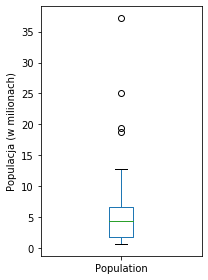

In [18]:
ax = (state['Population']/1_000_000).plot.box(figsize=(3, 4))
ax.set_ylabel('Populacja (w milionach)')

plt.tight_layout()
plt.show()

## Tablica częstości i histogramy
Metoda `cut` z pakietu _pandas_ rozdziela dane z zestawu danych na przedziały. Metoda ta zawiera wiele argumentów. W poniższym listingu tworzymy przedziały o takich samych rozmiarach. Metoda `value_counts` zwraca tablicę częstości.

In [19]:
binnedPopulation = pd.cut(state['Population'], 10)
print(binnedPopulation.value_counts())

(526935.67, 4232659.0]      24
(4232659.0, 7901692.0]      14
(7901692.0, 11570725.0]      6
(11570725.0, 15239758.0]     2
(33584923.0, 37253956.0]     1
(22577824.0, 26246857.0]     1
(18908791.0, 22577824.0]     1
(15239758.0, 18908791.0]     1
(29915890.0, 33584923.0]     0
(26246857.0, 29915890.0]     0
Name: Population, dtype: int64


In [20]:
# Tabela 1.5
binnedPopulation.name = 'binnedPopulation'
df = pd.concat([state, binnedPopulation], axis=1)
df = df.sort_values(by='Population')

groups = []
for group, subset in df.groupby(by='binnedPopulation'):
    groups.append({
        'Zakres': group,
        'Liczba': len(subset),
        'Stany': ','.join(subset.Abbreviation)
    })
print(pd.DataFrame(groups))

                     Zakres  Liczba  \
0    (526935.67, 4232659.0]      24   
1    (4232659.0, 7901692.0]      14   
2   (7901692.0, 11570725.0]       6   
3  (11570725.0, 15239758.0]       2   
4  (15239758.0, 18908791.0]       1   
5  (18908791.0, 22577824.0]       1   
6  (22577824.0, 26246857.0]       1   
7  (26246857.0, 29915890.0]       0   
8  (29915890.0, 33584923.0]       0   
9  (33584923.0, 37253956.0]       1   

                                               Stany  
0  WY,VT,ND,AK,SD,DE,MT,RI,NH,ME,HI,ID,NE,WV,NM,N...  
1          KY,LA,SC,AL,CO,MN,WI,MD,MO,TN,AZ,IN,MA,WA  
2                                  VA,NJ,NC,GA,MI,OH  
3                                              PA,IL  
4                                                 FL  
5                                                 NY  
6                                                 TX  
7                                                     
8                                                     
9                   

Pakiet _Pandas_ obsługuje także histogramy w analizie eksploracyjnej.

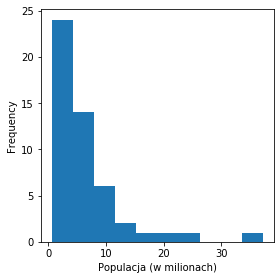

In [23]:
ax = (state['Population'] / 1_000_000).plot.hist(figsize=(4, 4))
ax.set_xlabel('Populacja (w milionach)')

plt.tight_layout()
plt.show()

## Szacowanie gęstości
Gęstość stanowi rozwiązanie alternatywne dla histogramów; dzięki niej widać wyraźniej rozkład punktów danych. Gładkość krzywej gęstości określamy za pomocą argumentu `bw_method`.

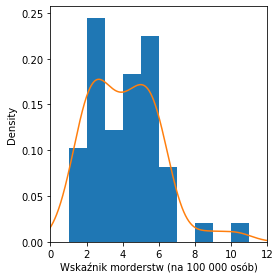

In [25]:
ax = state['Murder.Rate'].plot.hist(density=True, xlim=[0, 12], 
                                    bins=range(1,12), figsize=(4, 4))
state['Murder.Rate'].plot.density(ax=ax)
ax.set_xlabel('Wskaźnik morderstw (na 100 000 osób)')

plt.tight_layout()
plt.show()

# Badanie danych binarnych i skategoryzowanych

In [26]:
# Tabela 1.6
dfw = pd.read_csv(AIRPORT_DELAYS_CSV)
print(100 * dfw / dfw.values.sum())

     Carrier        ATC   Weather  Security    Inbound
0  23.022989  30.400781  4.025214  0.122937  42.428079


Pakiet _Pandas_ obsługuje rónież wykresy słupkowe służące do wyświetlania poszczególnych zmiennych skategoryzowanych.

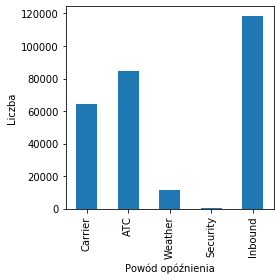

In [27]:
ax = dfw.transpose().plot.bar(figsize=(4, 4), legend=False)
ax.set_xlabel('Powód opóźnienia')
ax.set_ylabel('Liczba')

plt.tight_layout()
plt.show()

# Korelacja
Najpierw wczytujemy wymagane zestawy danych:

In [28]:
sp500_sym = pd.read_csv(SP500_SECTORS_CSV)
sp500_px = pd.read_csv(SP500_DATA_CSV, index_col=0)

In [29]:
# Tabela 1.7
# Określa symbole telekomunikacyjne
telecomSymbols = sp500_sym[sp500_sym['sector'] == 'telecommunications_services']['symbol']

# Filtruje dane dla zakresu dat od lipca 2012 r. do czerwca 2015 r.
telecom = sp500_px.loc[sp500_px.index >= '2012-07-01', telecomSymbols]
telecom.corr()
print(telecom)

                   T       CTL       FTR        VZ      LVLT
2012-07-02  0.422496  0.140847  0.070879  0.554180 -0.519998
2012-07-03 -0.177448  0.066280  0.070879 -0.025976 -0.049999
2012-07-05 -0.160548 -0.132563  0.055128 -0.051956 -0.180000
2012-07-06  0.342205  0.132563  0.007875  0.140106 -0.359999
2012-07-09  0.136883  0.124279 -0.023626  0.253943  0.180000
...              ...       ...       ...       ...       ...
2015-06-25  0.049342 -1.600000 -0.040000 -0.187790 -0.330002
2015-06-26 -0.256586  0.039999 -0.070000  0.029650 -0.739998
2015-06-29 -0.098685 -0.559999 -0.060000 -0.504063 -1.360000
2015-06-30 -0.503298 -0.420000 -0.070000 -0.523829  0.199997
2015-07-01 -0.019737  0.080000 -0.050000  0.355811  0.139999

[754 rows x 5 columns]


Następnie skoncentrujmy się na zwrotach dla głównych funduszy (sector == 'etf'). 

In [30]:
etfs = sp500_px.loc[sp500_px.index > '2012-07-01', 
                    sp500_sym[sp500_sym['sector'] == 'etf']['symbol']]
print(etfs.head())

                 XLI       QQQ       SPY       DIA       GLD    VXX       USO  \
2012-07-02 -0.376098  0.096313  0.028223 -0.242796  0.419998 -10.40  0.000000   
2012-07-03  0.376099  0.481576  0.874936  0.728405  0.490006  -3.52  0.250000   
2012-07-05  0.150440  0.096313 -0.103487  0.149420  0.239991   6.56 -0.070000   
2012-07-06 -0.141040 -0.491201  0.018819 -0.205449 -0.519989  -8.80 -0.180000   
2012-07-09  0.244465 -0.048160 -0.056445 -0.168094  0.429992  -0.48  0.459999   

                 IWM       XLE       XLY       XLU       XLB       XTL  \
2012-07-02  0.534641  0.028186  0.095759  0.098311 -0.093713  0.019076   
2012-07-03  0.926067  0.995942  0.000000 -0.044686  0.337373  0.000000   
2012-07-05 -0.171848 -0.460387  0.306431 -0.151938  0.103086  0.019072   
2012-07-06 -0.229128  0.206706  0.153214  0.080437  0.018744 -0.429213   
2012-07-09 -0.190939 -0.234892 -0.201098 -0.035751 -0.168687  0.000000   

                 XLV       XLP       XLF       XLK  
2012-07-02 -0.0

Z powodu znacznej liczby kolumn w tej tabeli analiza macierzy korelacji okazuje się bardzo żmudna i o wiele wygodniej jest zilustrować korelację w postaci mapy cieplnej. Pakiet _seaborn_ zawiera wygodną implementację map cieplnych.

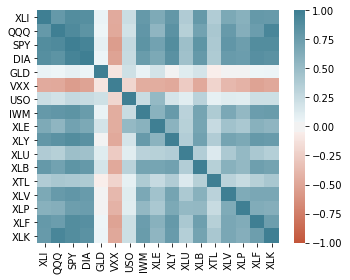

In [31]:
fig, ax = plt.subplots(figsize=(5, 4))
ax = sns.heatmap(etfs.corr(), vmin=-1, vmax=1, 
                 cmap=sns.diverging_palette(20, 220, as_cmap=True),
                 ax=ax)

plt.tight_layout()
plt.show()

Powyższa mapa cieplna jest czytelna w przypadku, gdy mamy możliwość oglądania jej w kolorze. W przypadku wykresów czarno-białych musimy także zwizualizować kierunek. Poniższy listing wizualizuje siłę korelację za pomocą elips.

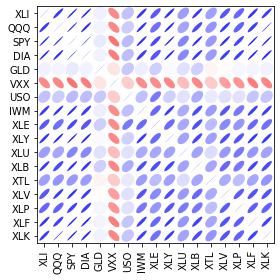

In [32]:
from matplotlib.collections import EllipseCollection
from matplotlib.colors import Normalize

def plot_corr_ellipses(data, figsize=None, **kwargs):
    ''' https://stackoverflow.com/a/34558488 '''
    M = np.array(data)
    if not M.ndim == 2:
        raise ValueError('Dane muszą być tablicą dwuwymiarową.')
    fig, ax = plt.subplots(1, 1, figsize=figsize, subplot_kw={'aspect':'equal'})
    ax.set_xlim(-0.5, M.shape[1] - 0.5)
    ax.set_ylim(-0.5, M.shape[0] - 0.5)
    ax.invert_yaxis()

    # współrzędne xy środka każdej elipsy
    xy = np.indices(M.shape)[::-1].reshape(2, -1).T

    # wyznacza względne rozmiary osi dłuższej/krótszej zgodnie z siłą korelacji dodatniej/ujemnej.
    w = np.ones_like(M).ravel() + 0.01
    h = 1 - np.abs(M).ravel() - 0.01
    a = 45 * np.sign(M).ravel()

    ec = EllipseCollection(widths=w, heights=h, angles=a, units='x', offsets=xy,
                           norm=Normalize(vmin=-1, vmax=1),
                           transOffset=ax.transData, array=M.ravel(), **kwargs)
    ax.add_collection(ec)

    # jeżeli dane mieszczą się w obiekcie DataFrame, nazwy rzędu/kolumny zostają użyte jako etykiety jednostek na osiach
    if isinstance(data, pd.DataFrame):
        ax.set_xticks(np.arange(M.shape[1]))
        ax.set_xticklabels(data.columns, rotation=90)
        ax.set_yticks(np.arange(M.shape[0]))
        ax.set_yticklabels(data.index)

    return ec

m = plot_corr_ellipses(etfs.corr(), figsize=(5, 4), cmap='bwr_r')
cb = fig.colorbar(m)
cb.set_label('Współczynnik korelacji')

plt.tight_layout()
plt.show()

## Wykres punktowy
Pakiet _pandas_ obsługuje proste wykresy punktowe. Wartość znacznika `$\u25EF$` wyznacza okrąg dla każdego punktu.

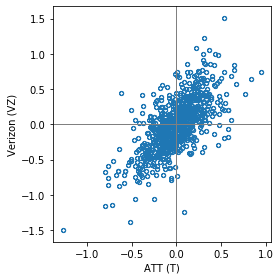

In [33]:
ax = telecom.plot.scatter(x='T', y='VZ', figsize=(4, 4), marker='$\u25EF$')
ax.set_xlabel('ATT (T)')
ax.set_ylabel('Verizon (VZ)')
ax.axhline(0, color='grey', lw=1)
ax.axvline(0, color='grey', lw=1)

plt.tight_layout()
plt.show()

Line2D(_line1)


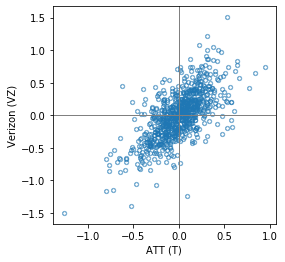

In [34]:
ax = telecom.plot.scatter(x='T', y='VZ', figsize=(4, 4), marker='$\u25EF$', alpha=0.5)
ax.set_xlabel('ATT (T)')
ax.set_ylabel('Verizon (VZ)')
ax.axhline(0, color='grey', lw=1)
print(ax.axvline(0, color='grey', lw=1))

# Badanie dwóch lub więcej zmiennych
Wczytujemy zestaw danych kc_tax i filtrujemy go na podstawie zróżnicowania kryteriów:

In [35]:
kc_tax = pd.read_csv(KC_TAX_CSV)
kc_tax0 = kc_tax.loc[(kc_tax.TaxAssessedValue < 750000) & 
                     (kc_tax.SqFtTotLiving > 100) &
                     (kc_tax.SqFtTotLiving < 3500), :]
print(kc_tax0.shape)

(432693, 3)


## Wykres hexagonal binning  i kontury 
### Przedstawianie danych numerycznych względem danych numerycznych

W przypadku dużej liczby punktów danych wykres punktowy przestaje być czytelny. Przydatniejsze stają się metody wizualizujące gęstość. Jednym z lepszych rozwiązań jest metoda `hexbin` z ramek danych _pandas_.

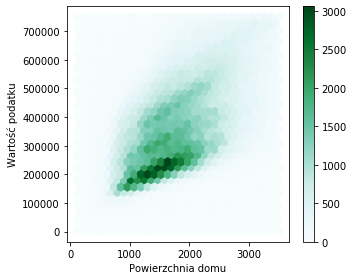

In [36]:
ax = kc_tax0.plot.hexbin(x='SqFtTotLiving', y='TaxAssessedValue',
                         gridsize=30, sharex=False, figsize=(5, 4))
ax.set_xlabel('Powierzchnia domu')
ax.set_ylabel('Wartość podatku')

plt.tight_layout()
plt.show()

Metoda kdeplot z pakietu _seaborn_ stanowi dwuwymiarowe rozszerzenie wykresu gęstości. 

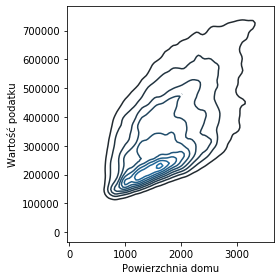

In [37]:
fig, ax = plt.subplots(figsize=(4, 4))
ax = sns.kdeplot(kc_tax0.SqFtTotLiving, kc_tax0.TaxAssessedValue, ax=ax)
ax.set_xlabel('Powierzchnia domu')
ax.set_ylabel('Wartość podatku')

plt.tight_layout()
plt.show()

## Dwie zmienne skategoryzowane
Wczytujemy zestaw danych `lc_loans`:

In [38]:
lc_loans = pd.read_csv(LC_LOANS_CSV)

In [39]:
# Tabela 1.8(1)
crosstab = lc_loans.pivot_table(index='grade', columns='status', 
                                aggfunc=lambda x: len(x), margins=True)
print(crosstab)

status  Charged Off  Current  Fully Paid  Late     All
grade                                                 
A              1562    50051       20408   469   72490
B              5302    93852       31160  2056  132370
C              6023    88928       23147  2777  120875
D              5007    53281       13681  2308   74277
E              2842    24639        5949  1374   34804
F              1526     8444        2328   606   12904
G               409     1990         643   199    3241
All           22671   321185       97316  9789  450961


In [40]:
# Tabela 1.8(2)
df = crosstab.copy().loc['A':'G',:]
df.loc[:,'Charged Off':'Late'] = df.loc[:,'Charged Off':'Late'].div(df['All'], axis=0)
df['All'] = df['All'] / sum(df['All'])
perc_crosstab = df
print(perc_crosstab)

status  Charged Off   Current  Fully Paid      Late       All
grade                                                        
A          0.021548  0.690454    0.281528  0.006470  0.160746
B          0.040054  0.709013    0.235401  0.015532  0.293529
C          0.049828  0.735702    0.191495  0.022974  0.268039
D          0.067410  0.717328    0.184189  0.031073  0.164708
E          0.081657  0.707936    0.170929  0.039478  0.077177
F          0.118258  0.654371    0.180409  0.046962  0.028614
G          0.126196  0.614008    0.198396  0.061401  0.007187


## Dane kategoryzowane i numeryczne
Boxploty kolumny w pakiecie _Pandas_ można pogrupować ze względu na różne kolumny.

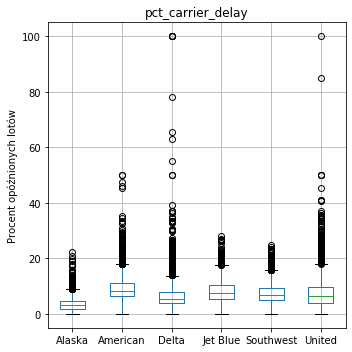

In [41]:
airline_stats = pd.read_csv(AIRLINE_STATS_CSV)
airline_stats.head()
ax = airline_stats.boxplot(by='airline', column='pct_carrier_delay',
                           figsize=(5, 5))
ax.set_xlabel('')
ax.set_ylabel('Procent opóźnionych lotów')
plt.suptitle('')

plt.tight_layout()
plt.show()

Pakiet _Pandas_ obsługuje także odmianę boxplotów o zwaną _wykresami skrzypcowymi_. 

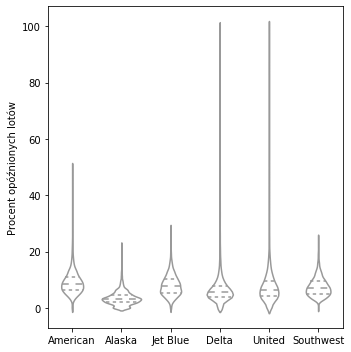

In [42]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.violinplot(airline_stats.airline, airline_stats.pct_carrier_delay,
               ax=ax, inner='quartile', color='white')
ax.set_xlabel('')
ax.set_ylabel('Procent opóźnionych lotów')

plt.tight_layout()
plt.show()

## Wizualizacja wielu zmiennych

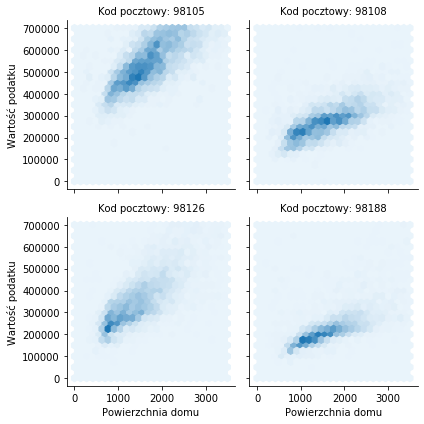

In [44]:
zip_codes = [98188, 98105, 98108, 98126]
kc_tax_zip = kc_tax0.loc[kc_tax0.ZipCode.isin(zip_codes),:]
kc_tax_zip

def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=25, cmap=cmap, **kwargs)

g = sns.FacetGrid(kc_tax_zip, col='ZipCode', col_wrap=2)
g.map(hexbin, 'SqFtTotLiving', 'TaxAssessedValue', 
      extent=[0, 3500, 0, 700000])
g.set_axis_labels('Powierzchnia domu', 'Wartość podatku')
g.set_titles('Kod pocztowy: {col_name:.0f}')

plt.tight_layout()
plt.show()